<a href="https://colab.research.google.com/github/ykkimhgu/DLIP-src/blob/main/Tutorial_Pytorch/Assignment_PyTorch_T3_3_Transfer_Learning_using_Pre_trained_Models_(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DLIP Tutorial - PyTorch**
# Transfer Learning using Pre-trained Models (Classification) - Assignment

Y.-K. Kim
(updated 2022. 5. 10) 

===================

Create a CNN model 'EfficientNet(efficientnet_b7)' and Train with Custom Dataset

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Environment Setup

Download Python modules and image data. 
- [download modules](https://drive.google.com/file/d/1hjrWkcvBTiI-5yGtWPvsYVdaE7YLNWDo/view?usp=sharing)
- [download dataset(cat/dog)](https://drive.google.com/file/d/1KYOAxXDIqp_hhE97WWQ_C8TeGFHWkxqG/view?usp=sharingg)


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from pytorch_classification_modules.set_parameter_requires_grad import set_parameter_requires_grad
from Exercise.initialize_model import initialize_model
from Exercise.train import train
from Exercise.test import test

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 


Using cuda device
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


# MODEL

Basically, the classification models provided by torchvision are trained on ImageNet and consist of 1000 output layers.

However, in the model for fine-tuning with other datasets, the number of output layers should be different depending on the class.

Here, we use the initialize_model() function provided in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) to change the output stage of the model.

initialize_model() is a function that helps to initialize the fine-tuning of some models.

If the model is not in the function, the output layer information can be known by printing the model with the print() function.

In [25]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = "efficientnet-b7"

# Number of classes in the dataset
num_classes = 2

feature_extract = True   # True: only update the reshaped layer params, False: finetune the whole model, 

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)  
model_ft = model_ft.to(device)

from torchsummary import summary
summary(model_ft, (3,input_size,input_size))

C:\ProgramData\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

# Prepare Datasets: kaggle cats and dogs

The images in the prepared dataset have different sizes. In order to be used as a learning model, the following process is required. (refer to part2)

- Assign the images in the folder to training/test data for learning
- Same pre-processing as ImageNet data for input of learning model

In [26]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
import os

data_dir = "D:/DLIP/DLIP_Python/Exercise/kagglecatsanddogs/PetImages"

### ADD YOUR CODE HERE

transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

Initializing Datasets and Dataloaders...


Use DataLoader to make dataset iterable.

In [33]:
training_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
test_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])

batch_size = 4

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}  X data type  {X.dtype}")
    print(f"Shape of Y: {y.shape} Y data type {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([4, 3, 224, 224])  X data type  torch.float32
Shape of Y: torch.Size([4]) Y data type torch.int64


# Optimization Setup

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

- Linear regression->Mean Squared Error
- Classification->Cross entropy

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Train and Test the model

In [35]:
### ADD YOUR CODE HERE
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_ft, loss_fn, optimizer, device, 100)
    test(test_dataloader, model_ft, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.290576  [    0/17500]
loss: 0.172208  [  400/17500]
loss: 0.434226  [  800/17500]
loss: 0.974940  [ 1200/17500]
loss: 0.434728  [ 1600/17500]
loss: 0.135024  [ 2000/17500]
loss: 0.415420  [ 2400/17500]
loss: 0.194947  [ 2800/17500]
loss: 0.893881  [ 3200/17500]
loss: 0.038511  [ 3600/17500]
loss: 0.516803  [ 4000/17500]
loss: 0.129722  [ 4400/17500]
loss: 0.472479  [ 4800/17500]
loss: 0.189128  [ 5200/17500]
loss: 0.848606  [ 5600/17500]
loss: 0.203038  [ 6000/17500]
loss: 0.113601  [ 6400/17500]
loss: 0.261726  [ 6800/17500]
loss: 0.704752  [ 7200/17500]
loss: 0.524795  [ 7600/17500]
loss: 0.324358  [ 8000/17500]
loss: 0.186427  [ 8400/17500]
loss: 0.669930  [ 8800/17500]
loss: 0.022382  [ 9200/17500]
loss: 0.292826  [ 9600/17500]
loss: 0.183004  [10000/17500]
loss: 0.108564  [10400/17500]
loss: 0.078784  [10800/17500]
loss: 0.139519  [11200/17500]
loss: 0.073697  [11600/17500]
loss: 0.796315  [12000/17500]
loss: 0.223631  [12400/17500]


C:\ProgramData\miniconda3\envs\py39\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Test Error: 
 Accuracy: 95.1%, Avg loss: 0.215829 

Epoch 2
-------------------------------
loss: 0.169183  [    0/17500]
loss: 0.062584  [  400/17500]
loss: 0.128103  [  800/17500]
loss: 0.366973  [ 1200/17500]
loss: 0.756274  [ 1600/17500]
loss: 0.059263  [ 2000/17500]
loss: 1.002753  [ 2400/17500]
loss: 0.398823  [ 2800/17500]
loss: 0.579142  [ 3200/17500]
loss: 0.085765  [ 3600/17500]
loss: 0.120667  [ 4000/17500]
loss: 0.161648  [ 4400/17500]
loss: 0.644750  [ 4800/17500]
loss: 0.575635  [ 5200/17500]
loss: 0.519168  [ 5600/17500]
loss: 0.270553  [ 6000/17500]
loss: 0.091021  [ 6400/17500]
loss: 0.551612  [ 6800/17500]
loss: 0.035695  [ 7200/17500]
loss: 0.343368  [ 7600/17500]
loss: 0.962865  [ 8000/17500]
loss: 0.386301  [ 8400/17500]
loss: 0.206179  [ 8800/17500]
loss: 0.162153  [ 9200/17500]
loss: 0.855045  [ 9600/17500]
loss: 0.268308  [10000/17500]
loss: 0.580041  [10400/17500]
loss: 0.347936  [10800/17500]
loss: 1.432716  [11200/17500]
loss: 0.361369  [11600/17500]
loss: 0.

# Visualize test results

Select random test images and evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


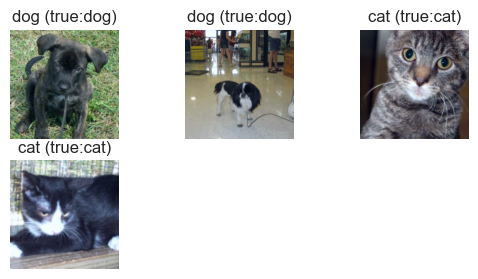

In [36]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    pred = model_ft(images)
    _, predicted = torch.max(pred.data, 1);

figure = plt.figure()
N_image = min(batch_size, 9)
classification = ['cat','dog']
for index in range(N_image):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classification[labels[index]]}")
    plt.title(f"{classification[predicted[index].item()]} (true:{classification[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.224  + 0.456).cpu().numpy().squeeze(), (1, 2, 0)))  

Plot heatmap (confusion matrix)

C:\ProgramData\miniconda3\envs\py39\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


      cat   dog
cat  3461   288
dog    64  3684


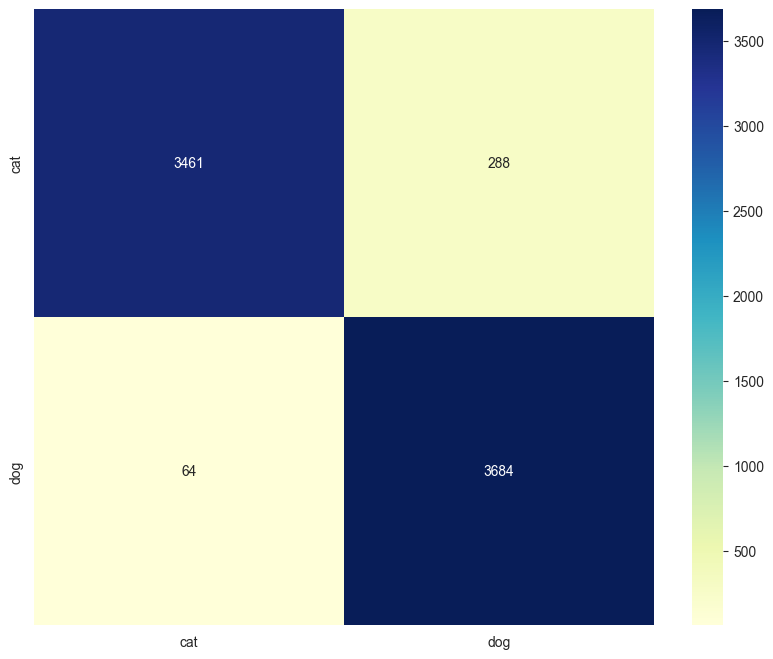

In [37]:
heatmap = pd.DataFrame(data=0,index=classification,columns=classification)

for images, labels in test_dataloader:
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label, predicted_label] += 1
print(heatmap)
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

# Saving Models
* save the structure of this class together with the model

In [38]:
torch.save(model_ft, f"{model_name}_ft(hymenoptera)_21900031_JinKwak.pth")